In [1]:
import pandas as pd
from PIL import Image, ImageDraw

In [2]:
DIRECTROY = 'data'
MODEL_PATH = 'models'

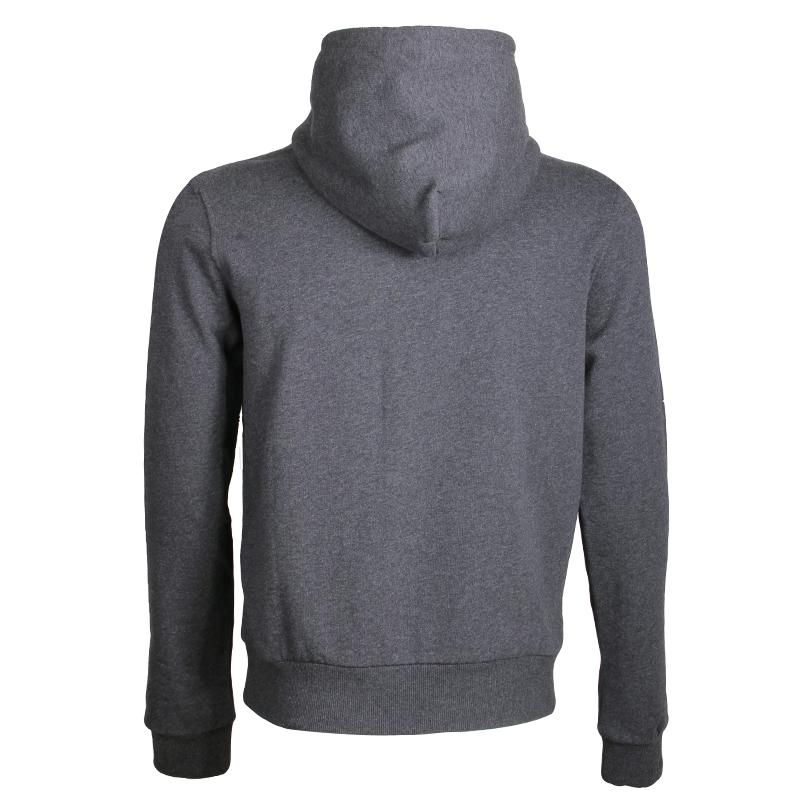

In [15]:
Image.open(f'./{DIRECTROY}/train/1.jpg').convert('RGB')

In [4]:
df_train = pd.read_csv(f'{DIRECTROY}/train.csv')
df_train.head()

,name,class,group
0,1.jpg,0,0
1,2.jpg,0,0
2,3.jpg,0,0
3,4.jpg,0,0
4,5.jpg,0,0


In [12]:
len(df_train['name'].unique())

141931

In [5]:
len(df_train['class'].unique())

9691

In [6]:
len(df_train['group'].unique())

360

There are 9691 labels in the dataset

<Axes: xlabel='class'>

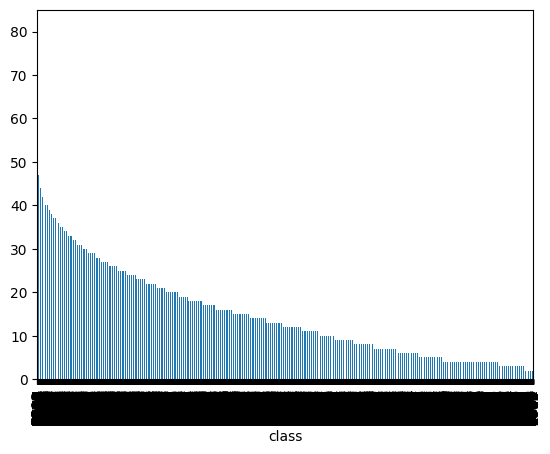

In [4]:
df_train['class'].value_counts().plot(kind='bar')

<Axes: xlabel='group'>

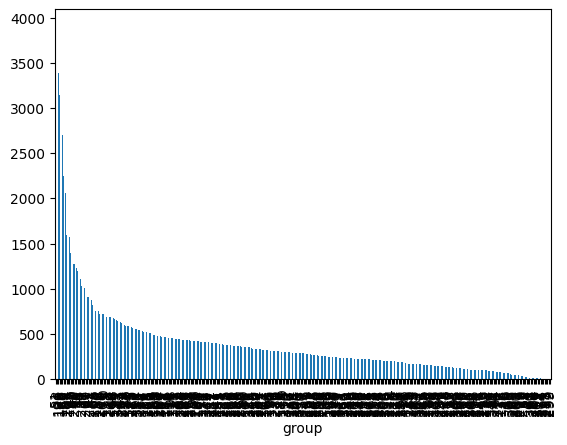

In [7]:
df_train['group'].value_counts().plot(kind='bar')